#### Comparing Euler's integration to Leapfrog

and semi-implicit Euler

Using the example of the Earth-Sun 2-body problem

TL;DR: Leapfrog and the semi-implicit variant of Euler are symplectic, which results in stable orbits over a long period of time. Standard Euler results in an unstable system - Earth quickly leaves Sun's gravitational well

In [158]:
from typing import Sequence
import numpy as np
from scipy.constants import G
class PhysObject:
    body_name: str
    body_mass: float
    body_vel: np.ndarray
    body_pos: np.ndarray
    
    def __init__(self, body_name, body_mass, body_vel, body_pos):
        self.body_name = body_name
        self.body_mass = body_mass
        self.body_vel = body_vel
        self.body_pos = body_pos
    
    def apply_force(self, force, dt):
        self.body_vel += force/self.body_mass * dt
    def update_position(self, dt):
        self.body_pos += self.body_vel * dt

def get_gravitational_force(body1: PhysObject, body2: PhysObject)->float:
    # Magnitude of the vector
    dist = np.linalg.norm(body1.body_pos - body2.body_pos)
    return (G*body1.body_mass*body2.body_mass)/(dist**2)

def get_forces_for_bodies(bodies: Sequence[PhysObject]):
    # Depends on order of the bodies
    # Ported from Rust code ported from Python, that's why it's weird...
    forces = []
    for body1 in bodies:
        for body2 in bodies:
            if body1.body_name == body2.body_name:
                continue
            force = get_gravitational_force(body1, body2)
            direction = body1.body_pos - body2.body_pos # Vector from 2 to 1
            direction = direction / np.linalg.norm(direction)
            forces.append(-(force*direction))
    return forces

In [159]:
def update_semi_implicit_euler(bodies: Sequence[PhysObject], dt: float):
    # We first update the velocity, and use the UPDATED velocity to update the position
    # Symplectic
    forces = get_forces_for_bodies(bodies)
    for i, body in enumerate(bodies):
        body.apply_force(forces[i],dt)
    for body in bodies:
        body.update_position(dt)

def update_euler(bodies: Sequence[PhysObject], dt: float):
    # Use the PAST velocity to update the position, then update the velocity
    # NOT symplectic
    forces = get_forces_for_bodies(bodies)
    for force, body in zip(forces, bodies):
        body.update_position(dt)
        body.apply_force(force, dt)

def update_leapfrog(bodies: Sequence[PhysObject], dt: float):
    # Second-order method
    forces = get_forces_for_bodies(bodies)
    for i, body in enumerate(bodies):
        body.apply_force(forces[i], dt*0.5)
    for body in bodies:
        body.update_position(dt)
    forces = get_forces_for_bodies(bodies)
    for i, body in enumerate(bodies):
        body.apply_force(forces[i], dt*0.5)

#### Integrating

In [160]:
# 90 days -  7_776_000 seconds 
# 30 days - 2_592_000 seconds
# 1 day - 86_400 seconds

deltatime = 2_592_000  # seconds
no_steps = 10_000

### Euler

In [161]:
sun = PhysObject("Sun", 1.988416e30, np.array([0,0],dtype=np.float64), np.array([0,0],dtype=np.float64))
earth = PhysObject("Earth", 5.9722e24, np.array([29.8e3,0.0],dtype=np.float64), np.array([0.0, 1.495978707e11],dtype=np.float64))
body_list = [sun, earth]
distances_euler = []
for _ in range(no_steps):
    update_euler(body_list, deltatime)
    distances_euler.append(np.linalg.norm(body_list[0].body_pos - body_list[1].body_pos))

### Semi-implicit Euler

In [162]:

sun = PhysObject("Sun", 1.988416e30, np.array([0,0],dtype=np.float64), np.array([0,0],dtype=np.float64))
earth = PhysObject("Earth", 5.9722e24, np.array([29.8e3,0.0],dtype=np.float64), np.array([0.0, 1.495978707e11],dtype=np.float64))
body_list = [sun, earth]
distances_semi_implicit_euler = []
for _ in range(no_steps):
    update_semi_implicit_euler(body_list, deltatime)
    distances_semi_implicit_euler.append(np.linalg.norm(body_list[0].body_pos - body_list[1].body_pos))


### Leapfrog

In [163]:

sun = PhysObject("Sun", 1.988416e30, np.array([0,0],dtype=np.float64), np.array([0,0],dtype=np.float64))
earth = PhysObject("Earth", 5.9722e24, np.array([29.8e3,0.0],dtype=np.float64), np.array([0.0, 1.495978707e11],dtype=np.float64))
body_list = [sun, earth]
distances_leapfrog = []
for _ in range(no_steps):
    update_leapfrog(body_list, deltatime)
    distances_leapfrog.append(np.linalg.norm(body_list[0].body_pos - body_list[1].body_pos))


### Plotting the distances

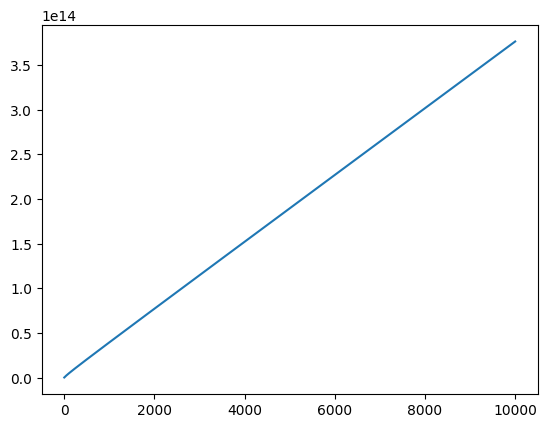

In [164]:
import matplotlib.pyplot as plt

plt.plot(distances_euler)

The system quickly degrades when using the standard Euler method - the distance between Earth and Sun goes to infinity

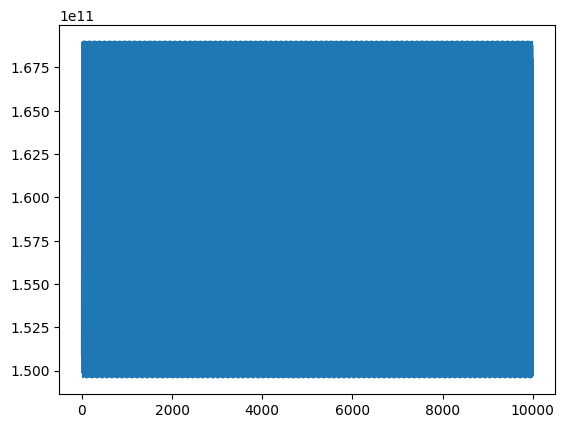

In [165]:
plt.plot(distances_leapfrog)

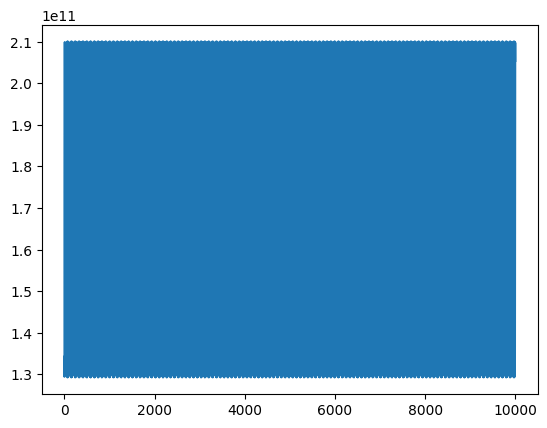

In [166]:
plt.plot(distances_semi_implicit_euler)

Both leapfrog and symplectic euler result in stable orbits

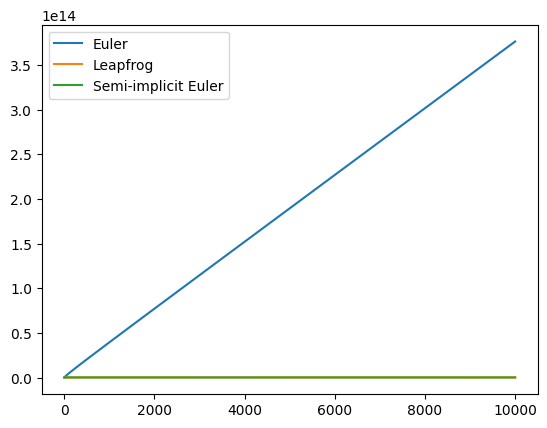

In [167]:
plt.plot(distances_euler, label='Euler')
plt.plot(distances_leapfrog, label='Leapfrog')
plt.plot(distances_semi_implicit_euler, label='Semi-implicit Euler')
plt.legend()

In [168]:
distances_euler[0]

np.float64(168362073189.1061)

In [169]:
distances_euler[-1]

np.float64(376629939609203.25)

In [170]:
np.max(distances_euler)

np.float64(376629939609203.25)

In [171]:
np.max(distances_leapfrog)

np.float64(168985492093.3268)

In [172]:
np.min(distances_euler)

np.float64(168362073189.1061)

In [173]:
np.min(distances_leapfrog)

np.float64(149597872118.06512)

#### We can also plot the moving average of distances to visualize this:

In [174]:
def moving_average(x, window_size):
    return np.convolve(x, np.ones(window_size), 'valid') / window_size

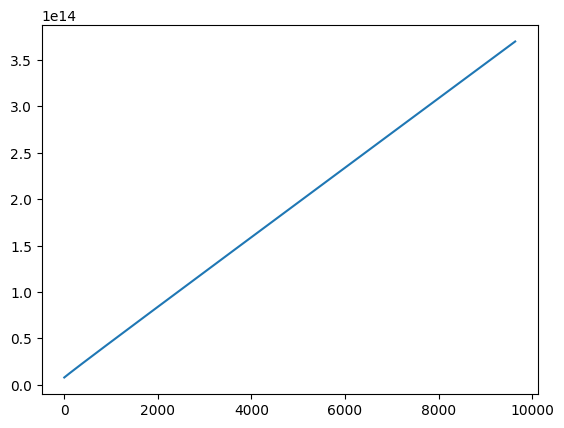

In [176]:
plt.plot(moving_average(distances_euler,365), label='Euler')

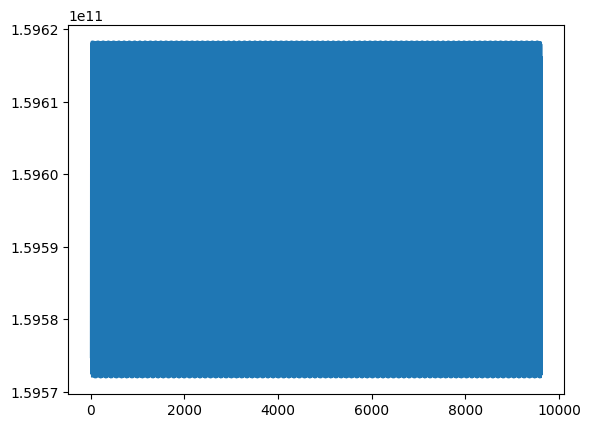

In [175]:
plt.plot(moving_average(distances_leapfrog,365), label='Leapfrog')

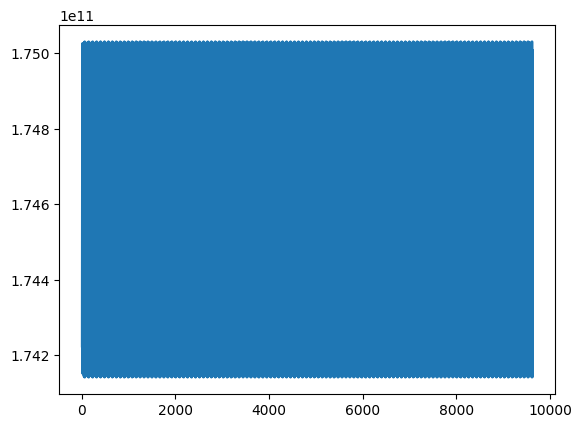

In [177]:
plt.plot(moving_average(distances_semi_implicit_euler,365), label='Semi-implicit Euler')